In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from konlpy.tag import Mecab
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import matplotlib.font_manager as fm
plt.rc('font', family=fm.FontProperties(fname="c:/Windows/Fonts/malgun.ttf").get_name())
from tqdm import tqdm
import re

In [2]:
hit_18=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2018.csv',encoding='cp949')
hit_19=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2019.csv',encoding='cp949')
hit_20=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2020.csv',encoding='cp949')
hit_21=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_HTS_2021.csv',encoding='cp949')

game=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_경기일정_2021.csv',encoding='cp949')

player_18=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2018.csv',encoding='cp949')
player_19=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2019.csv',encoding='cp949')
player_20=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2020.csv',encoding='cp949')
player_21=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_선수_2021.csv',encoding='cp949')

hitter_18=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2018.csv',encoding='cp949')
hitter_19=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2019.csv',encoding='cp949')
hitter_20=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2020.csv',encoding='cp949')
hitter_21=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_타자 기본_2021.csv',encoding='cp949')

team=pd.read_csv('제공데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_팀.csv',encoding='cp949')

submission=pd.read_excel('평가데이터/2021 빅콘테스트_데이터분석분야_챔피언리그_스포츠테크_평가데이터.xlsx')

- 76232 - 양의지
- 68050 - 강백호
- 75847 - 최정
- 67341 - 이정후
- 79192 - 채은성
- 78224 - 김재환
- 78513 - 전준우
- 76290 - 김현수
- 79215 - 박건우
- 67872 - 로맥

In [3]:
submission.loc[0,'OPS']=1.097
submission.PCODE[1]=76232;submission.PCODE[2]=68050;submission.PCODE[3]=75847;submission.PCODE[4]=67341;submission.PCODE[5]=79192
submission.PCODE[6]=78224;submission.PCODE[7]=78513;submission.PCODE[8]=76290;submission.PCODE[9]=79215;submission.PCODE[10]=67872;
#ops == 장타율 + 출루율

In [4]:
hit=pd.concat([hit_18,hit_19,hit_20,hit_21],ignore_index=True)
player=pd.concat([player_18,player_19,player_20,player_21],ignore_index=True)
hitter=pd.concat([hitter_18,hitter_19,hitter_20,hitter_21],ignore_index=True)

In [5]:
hit.columns=['연도', '경기코드', '타구코드', '선수코드', '팀코드', '이닝', '타구속도',
       '발사각도', '타격결과', '상대투수투구구속', '해당구장']
player.columns=['연도', '선수코드', '선수명', '팀코드', '포지션', '나이', '연봉']
hitter.columns=['연도', '선수코드', '경기', '타석', '타수', '타율', '안타', '홈런', '루타',
       '장타율', '희생플라이', '볼넷', '삼진', '고의4구', '사구', '병살타']

hitter['출루율']=(hitter.안타+hitter.볼넷+hitter.사구)/(hitter.타수+hitter.볼넷+hitter.사구+hitter.희생플라이)

#### hit

In [6]:
hit['상대팀코드']=hit.경기코드.str[-5:-1]

In [7]:
for i in tqdm(range(hit.shape[0])):
    hit['상대팀코드'].iloc[i]=hit.iloc[i].상대팀코드.replace(hit.iloc[i].팀코드,'')

100%|█████████████████████████████████████████████████████████████████████████| 120745/120745 [03:22<00:00, 597.10it/s]


In [8]:
hit['날짜']='20'+hit.타구코드.str.split('_').str[0]+hit.타구코드.str.split('_').str[1]
hit['날짜']=pd.to_datetime(hit.날짜)

hit['년']=hit.날짜.dt.year
hit['월']=hit.날짜.dt.month
hit['일']=hit.날짜.dt.day
hit['시간']=hit.날짜.dt.hour

---

## 타격정보 이용

### 1. 타격결과 별 타구속도의 분포

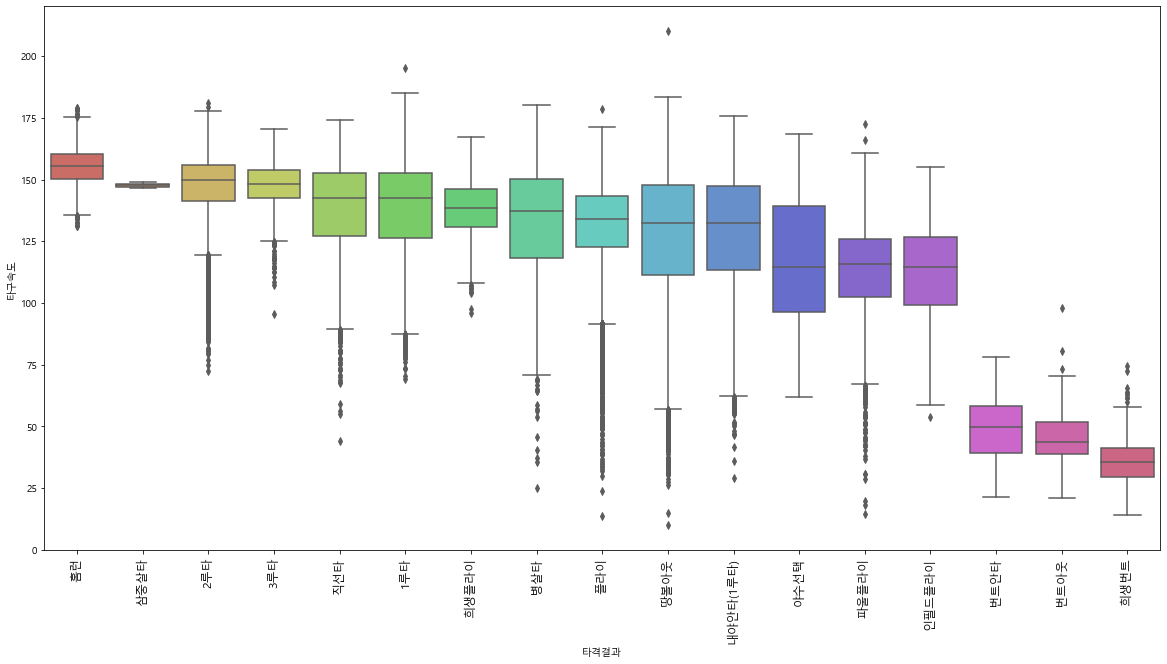

In [9]:
fig, ax= plt.subplots(figsize=(20,10))
sns.boxplot(x="타격결과", y="타구속도", data = hit, palette='hls'
            ,order=hit.groupby('타격결과')['타구속도'].mean().reset_index().sort_values(by='타구속도',ascending=False).타격결과)
plt.xticks(fontsize=12, rotation='vertical')
plt.show()

### 2. 타격결과 별 상대투수투구구속의 분포

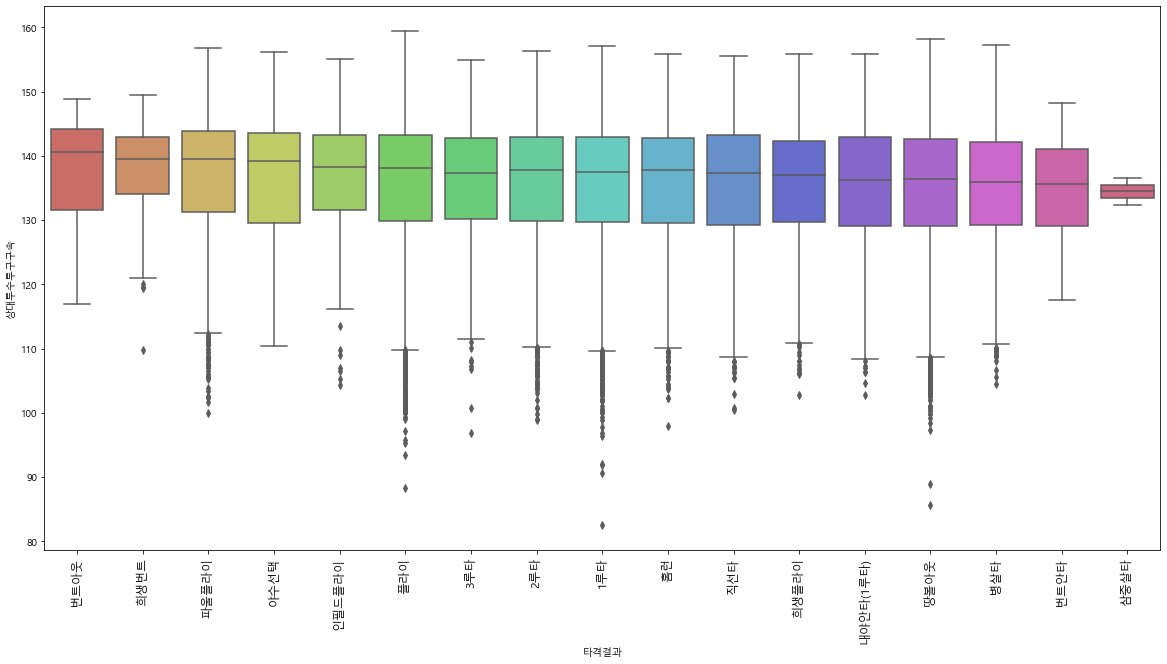

In [10]:
fig, ax= plt.subplots(figsize=(20,10))
sns.boxplot(x="타격결과", y="상대투수투구구속", data = hit, palette='hls'
            ,order=hit.groupby('타격결과')['상대투수투구구속'].mean().reset_index().sort_values(by='상대투수투구구속',ascending=False).타격결과)
plt.xticks(fontsize=12, rotation='vertical')
plt.show()

### 3. 월별 타구속도의 분포

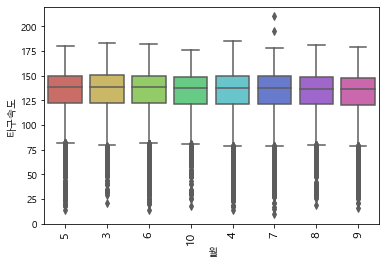

In [11]:
sns.boxplot(x="월", y="타구속도", data = hit, palette='hls'
            ,order=hit.groupby('월')['타구속도'].mean().reset_index().sort_values(by='타구속도',ascending=False).월)
plt.xticks(fontsize=12, rotation='vertical')
plt.show()

### 3-1. 타구결과 분포

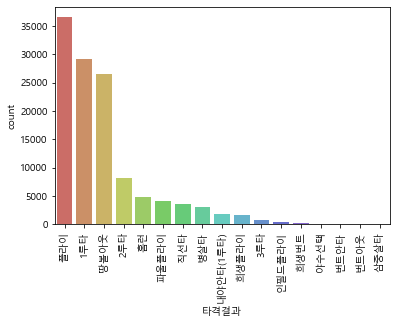

In [12]:
most_freq_aspect_labels = list(hit.groupby('타격결과')['타구속도'].count().sort_values(ascending=False).index)

ax1=sns.countplot(x='타격결과', data=hit,order=most_freq_aspect_labels, palette='hls')
ax1.set_xticklabels(most_freq_aspect_labels, rotation='vertical')
plt.show()

### 3-2 월별 타구결과의 분포

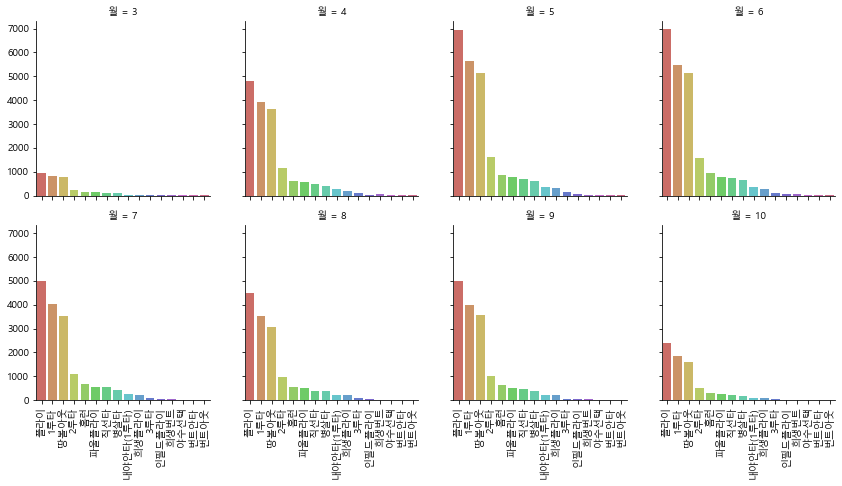

In [13]:
grid1 = sns.FacetGrid(hit,  col='월',col_wrap=4)

grid1.map_dataframe(sns.countplot, x='타격결과',order=most_freq_aspect_labels[:-1], palette='hls')
grid1.set_xticklabels(most_freq_aspect_labels[:-1], rotation='vertical') #작은 그래프들이 라벨들
plt.show()

In [14]:
tt=pd.merge(hit.groupby('월')['경기코드'].nunique().reset_index(),hit.groupby('월')['타격결과'].count().reset_index(),how='left',on='월')
tt['경기당타격']=tt['타격결과']/tt['경기코드'];tt

,월,경기코드,타격결과,경기당타격
0,3,75,3340,44.533333
1,4,338,16187,47.890533
2,5,482,23240,48.215768
3,6,481,23053,47.927235
4,7,342,16593,48.517544
5,8,295,14518,49.213559
6,9,333,16179,48.585586
7,10,155,7635,49.258065


왜 8월같이 다른 달이랑 다르게 경기수가 적은 이유가 뭔가하고 찾아보니까\
아시안게임같은 대회있으면 단체로 브레이크타임이라서 안한다고 하네요

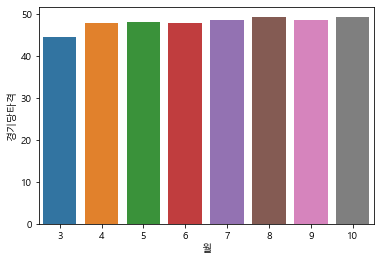

In [15]:
sns.barplot(x='월',y='경기당타격',data= tt)
plt.show()

### 3-3 시간별 타구결과의 분포

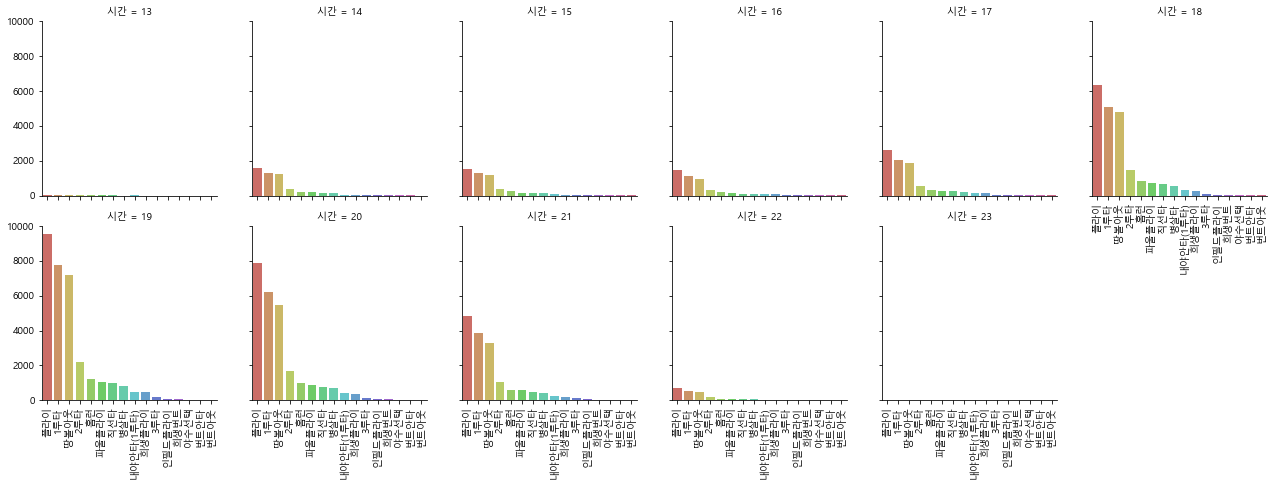

In [16]:
grid1 = sns.FacetGrid(hit,  col='시간',col_wrap=6)

grid1.map_dataframe(sns.countplot, x='타격결과',order=most_freq_aspect_labels[:-1], palette='hls')
grid1.set_xticklabels(most_freq_aspect_labels[:-1], rotation='vertical') #작은 그래프들이 라벨들
plt.show()

In [17]:
tt=pd.merge(hit.groupby('시간')['경기코드'].nunique().reset_index(),hit.groupby('시간')['타격결과'].count().reset_index(),how='left',on='시간')
tt['경기당타격']=tt['타격결과']/tt['경기코드'];tt

,시간,경기코드,타격결과,경기당타격
0,13,28,28,1.000000
1,14,337,5306,15.744807
2,15,352,5270,14.971591
3,16,375,4668,12.448000
4,17,704,8533,12.120739
5,18,2158,21174,9.811863
6,19,2145,32051,14.942191
7,20,2001,25637,12.812094
8,21,1650,15645,9.481818
9,22,433,2287,5.281755


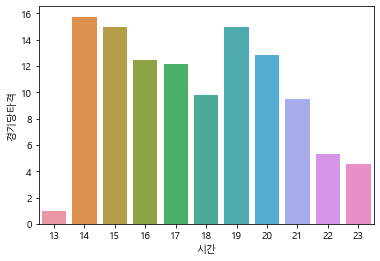

In [18]:
sns.barplot(x='시간',y='경기당타격',data= tt)
plt.show()

### 3-4 이닝별 타구속도의 분포

발사각도 비슷

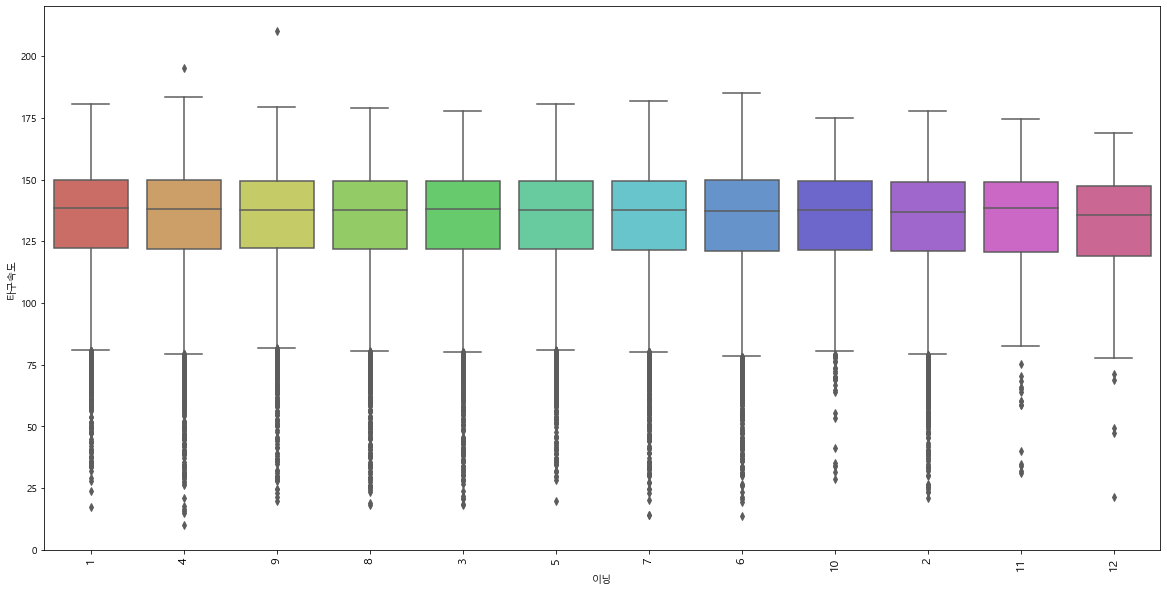

In [19]:
fig, ax= plt.subplots(figsize=(20,10))
sns.boxplot(x="이닝", y="타구속도", data = hit, palette='hls'
            ,order=hit.groupby('이닝')['타구속도'].mean().reset_index().sort_values(by='타구속도',ascending=False).이닝)
plt.xticks(fontsize=12, rotation='vertical')
plt.show()

### 4-1. 타격결과 별 발사각도의 분포

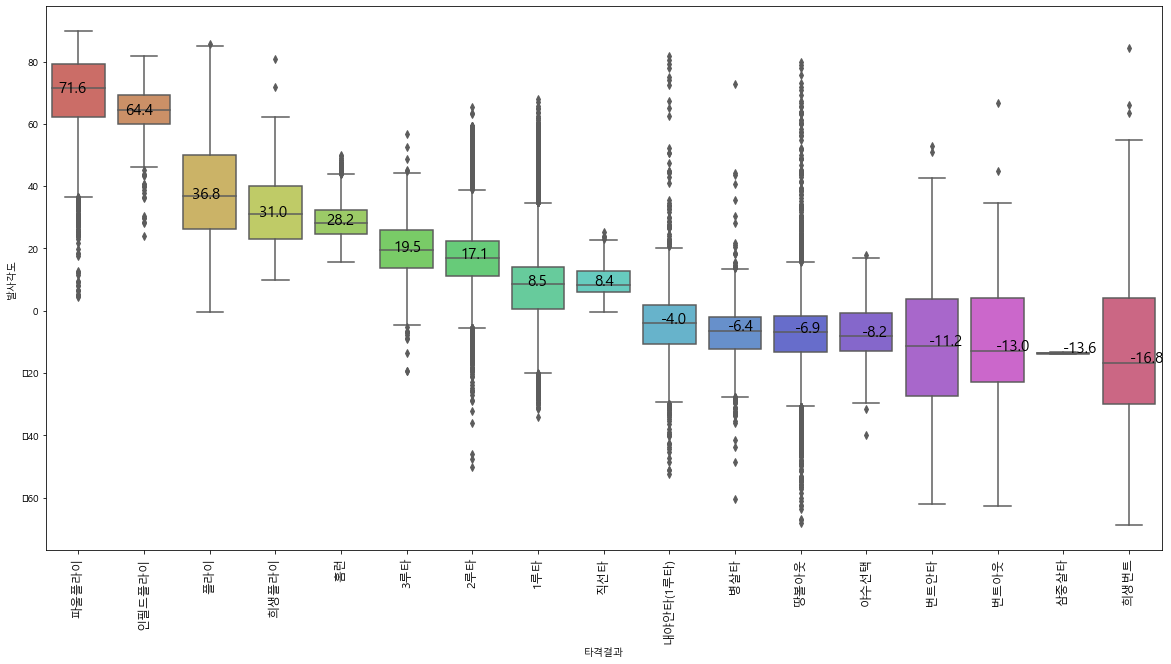

In [20]:
fig, ax= plt.subplots(figsize=(20,10))
b=hit.groupby('타격결과')['발사각도'].median().reset_index().sort_values(by='발사각도',ascending=False).reset_index()
sns.boxplot(x="타격결과", y="발사각도", data = hit, palette='hls'
            ,order=b.타격결과)
for n in range(b.shape[0]):
    plt.text((n-0.3)*1.02, b['발사각도'][n]*0.98, 
             round(b['발사각도'][n],1), fontsize=15)
plt.xticks(fontsize=12, rotation='vertical')
plt.show()

### 4-2. 타격결과 별 타구속도의 분포

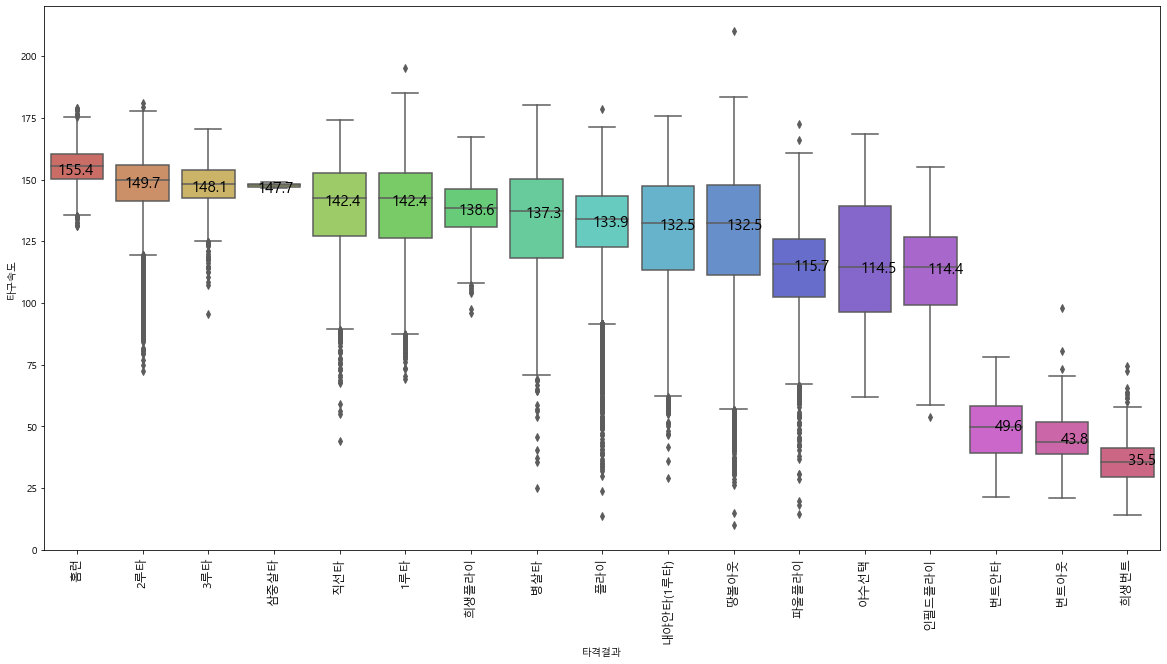

In [21]:
fig, ax= plt.subplots(figsize=(20,10))
b=hit.groupby('타격결과')['타구속도'].median().reset_index().sort_values(by='타구속도',ascending=False).reset_index()
sns.boxplot(x="타격결과", y="타구속도", data = hit, palette='hls'
            ,order=b.타격결과)
for n in range(b.shape[0]):
    plt.text((n-0.3)*1.02, b['타구속도'][n]*0.98, 
             round(b['타구속도'][n],1), fontsize=15)
plt.xticks(fontsize=12, rotation='vertical')
plt.show()### 4-1. 타격결과 별 발사각도의 분포

발사각과 타구속도의 관계에 있어서 적정치여야 좋은 결과를 얻을 수 있다.\
그렇기 때문에 배럴을 잘 구축하는 것이 중요하다.

### 5. 구장별 홈런수가 어떻게 되는지

In [9]:
ga=hit.groupby('해당구장')['경기코드'].nunique().reset_index()
ga.columns=['해당구장','경기수']
ga=pd.merge(hit[hit.타격결과=='홈런'].groupby('해당구장')['타격결과'].count().reset_index().sort_values(by='타격결과',ascending=False),ga,how='left',on='해당구장')
ga.columns=['해당구장','홈런수','경기수']
ga['한경기홈런비율']=(ga['홈런수']/ga['경기수'])
ga=ga.sort_values(by='한경기홈런비율',ascending=False);ga

,해당구장,홈런수,경기수,한경기홈런비율
9,마산,185,72,2.569444
1,문학,648,257,2.521401
2,대구,588,246,2.390244
7,창원,413,178,2.320225
3,사직,498,237,2.101266
4,수원,478,255,1.874510
5,대전,440,239,1.841004
6,광주,427,253,1.687747
8,고척,376,256,1.468750
0,잠실,679,508,1.336614


#### 잠실이 LG와 두산이 같이 사용하기 때문에 경기수가 많아 홈런이 많다. 문학은 경기수가 잠실의 절반인데 홈런수는 비슷하다. 
#### 이를 보았을 떄 구장에 따라 타격의 영향이 다르다는 것을 볼 수 있다. 구장의 크기도 영향을 미칠 수 있다는 것이다.
    
구장 크기 손롤링 하였음

In [10]:
ga[['좌우','중간','좌우_중간','펜스']]=[0,0,0,0]
ga.loc[ga.해당구장=='마산',['좌우','중간','좌우_중간','펜스']]=[97,116,110,3.8]
ga.loc[ga.해당구장=='창원',['좌우','중간','좌우_중간','펜스']]=[101,122,123,3.3]
ga.loc[ga.해당구장=='문학',['좌우','중간','좌우_중간','펜스']]=[95,120,115,2.8]
ga.loc[ga.해당구장=='잠실',['좌우','중간','좌우_중간','펜스']]=[100,125,120,2.6]
ga.loc[ga.해당구장=='대구',['좌우','중간','좌우_중간','펜스']]=[99.5,122.5,107,3.6]
ga.loc[ga.해당구장=='사직',['좌우','중간','좌우_중간','펜스']]=[95,118,113,4.8]
ga.loc[ga.해당구장=='수원',['좌우','중간','좌우_중간','펜스']]=[98,120,115,4.0]
ga.loc[ga.해당구장=='대전',['좌우','중간','좌우_중간','펜스']]=[100,122,112,4.0]
ga.loc[ga.해당구장=='광주',['좌우','중간','좌우_중간','펜스']]=[99,121,116,2.6]
ga.loc[ga.해당구장=='고척',['좌우','중간','좌우_중간','펜스']]=[99,122,115.6,4]

In [11]:
ga.좌우.iloc[[0,1,2,3,4,5,6,7,9]].mean(),ga.중간.iloc[[0,1,2,3,4,5,6,7,9]].mean(),ga.좌우_중간.iloc[[0,1,2,3,4,5,6,7,9]].mean()

(98.27777777777777, 120.72222222222223, 114.55555555555556)

In [12]:
122*114.56/120.72

115.77468522200132

In [13]:
99*114.56/98.28

115.3992673992674

In [14]:
(115.3992673992674 + 115.77468522200132)/2

115.58697631063436

In [15]:
ga['팀코드']=['NC','SK','SS','NC','LT','KT','HH','HT','WO','OB']
ga=ga.reset_index(drop=True)

In [16]:
ga

,해당구장,홈런수,경기수,한경기홈런비율,좌우,중간,좌우_중간,펜스,팀코드
0,마산,185,72,2.569444,97.0,116.0,110.0,3.8,NC
1,문학,648,257,2.521401,95.0,120.0,115.0,2.8,SK
2,대구,588,246,2.390244,99.5,122.5,107.0,3.6,SS
3,창원,413,178,2.320225,101.0,122.0,123.0,3.3,NC
4,사직,498,237,2.101266,95.0,118.0,113.0,4.8,LT
5,수원,478,255,1.874510,98.0,120.0,115.0,4.0,KT
6,대전,440,239,1.841004,100.0,122.0,112.0,4.0,HH
7,광주,427,253,1.687747,99.0,121.0,116.0,2.6,HT
8,고척,376,256,1.468750,99.0,122.0,115.6,4.0,WO
9,잠실,679,508,1.336614,100.0,125.0,120.0,2.6,OB


### 5-1. 한경기 홈런 비율과 구장 규격간의 관계

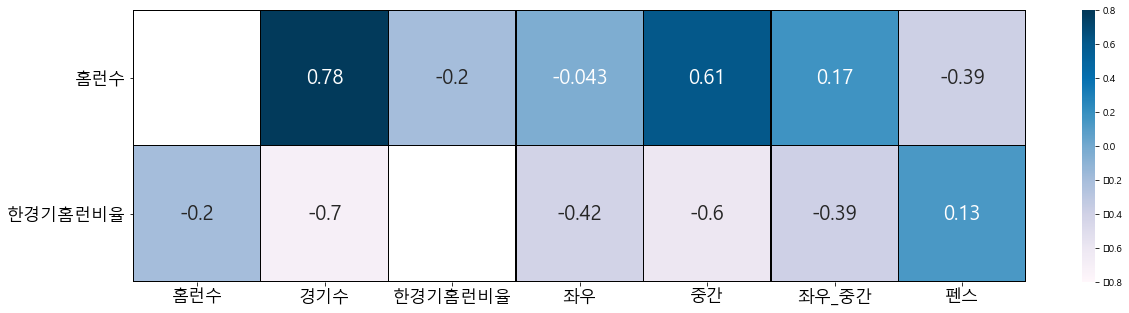

In [30]:
fig,ax=plt.subplots(figsize=(20,5))
sns.heatmap(ga.corr().iloc[[0,2],][ga.corr().iloc[[0,2],]!=1], cmap='PuBu', annot=True, vmin=-0.8, vmax=0.8, linewidths=.5, annot_kws = {"size" : 20},linecolor='black')
plt.xticks(size=17) 
plt.yticks(rotation=0,size=17) 
plt.show()

---

## 타자 정보 이용

In [17]:
hitter_all=pd.merge(hitter,player, how='left', on=['연도','선수코드'])
# 화이트라는 선수 한번 있는데 연봉 없어서 그냥 제외
hitter_all=hitter_all.drop(589,axis=0).reset_index().drop('index',axis=1)
hitter_all['OPS']=hitter_all['출루율']+hitter_all['장타율']

In [18]:
for i in tqdm(range(hitter_all.shape[0])):
    if hitter_all['연봉'].iloc[i][-2:]=='만원':
        hitter_all['연봉'].iloc[i]=float(hitter_all.loc[i,'연봉'][:-2])*10000
    else:
        hitter_all['연봉'].iloc[i]=float(hitter_all.loc[i,'연봉'][:-2])*1150
hitter_all['연봉']=hitter_all['연봉'].astype(float)

100%|████████████████████████████████████████████████████████████████████████████| 1097/1097 [00:00<00:00, 3572.32it/s]


### 1. 경기수, 타석, 타율, 출루율, 장타율,ops, 연봉, 안타, 홈런, 루타 등은 모두 양의 관계일 것이다

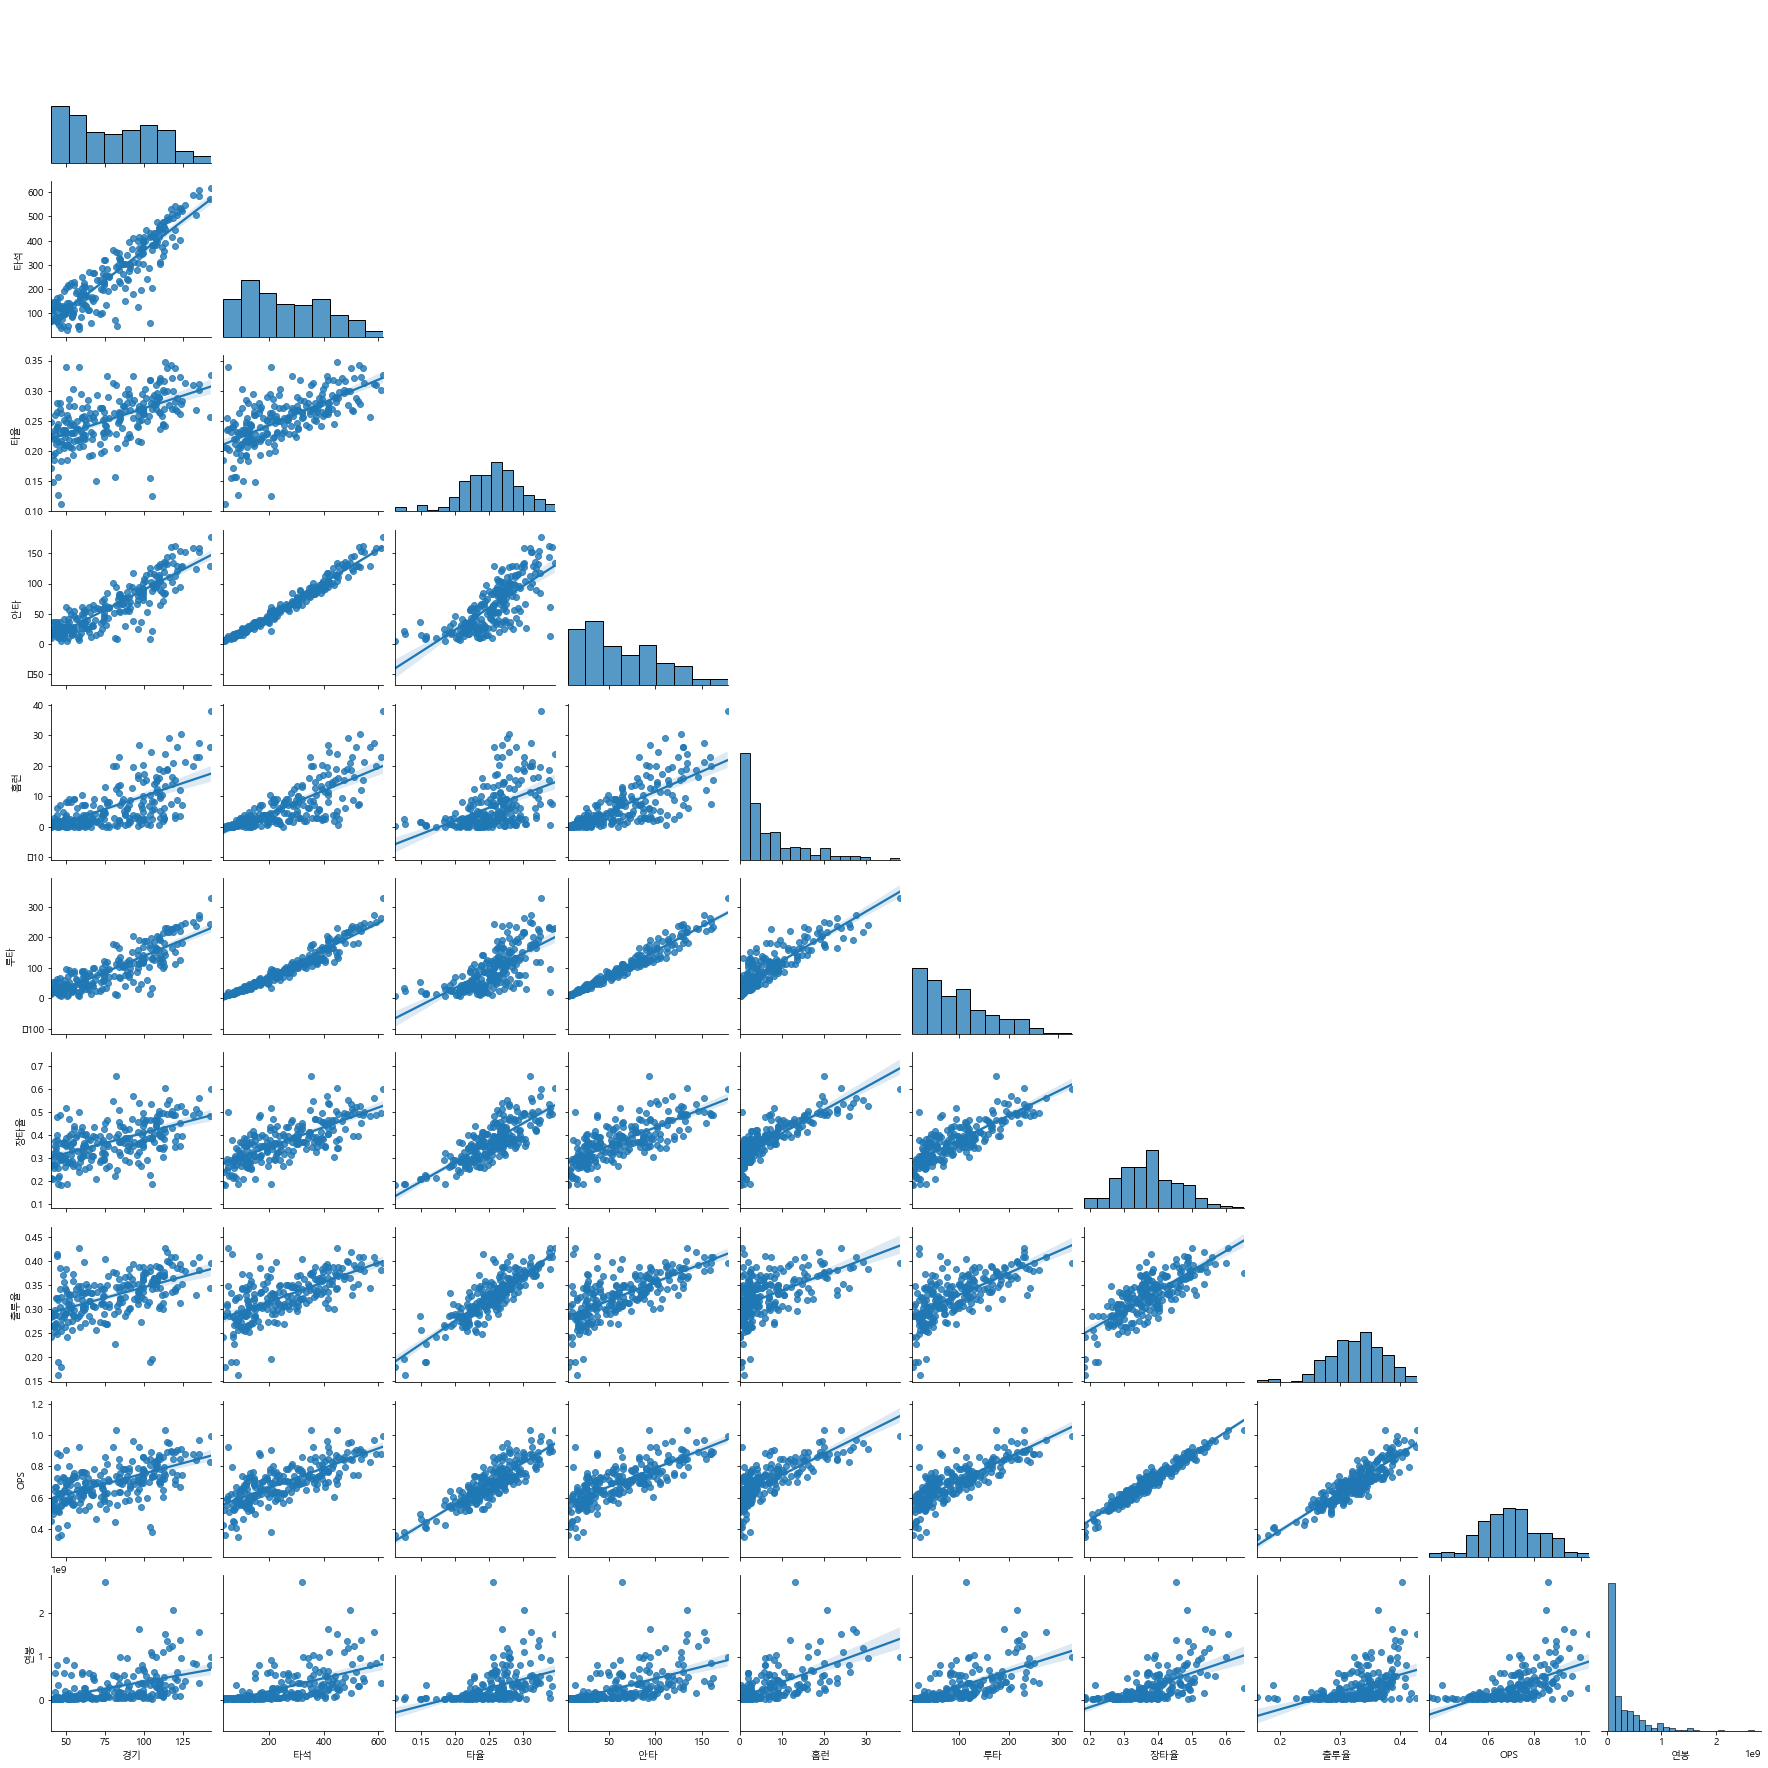

In [33]:
data=hitter_all.groupby('선수코드')[['경기','타석','타율','안타','홈런','루타','장타율','출루율','OPS','연봉']].mean().reset_index()
sns.pairplot(data[data.경기>40], corner=True, kind='reg', vars=['경기','타석','타율','안타','홈런','루타','장타율','출루율','OPS','연봉'])
plt.show() #corner 대각선을 기준 한쪽 없애기

- 경기일정에 있는 데이터 중 9/15 부터 10/8 까지의 선수 10명에 대한 ops, 장타율, 출루율을 예측해주면 된다.
- ACG는 전반기, 후반기로 나누어져 있는 것이다.
- 시계열적으로 계절이나 이번 년도의 성적이 영향을 미칠 것이다. 
- 이번 올림픽을 다녀오고 아니고의 영향도 있을 것이다.
- 팀의 순위도 영향이 있을 것이다
- 상대 투수투구구속도 영향이 있을 것
- 선수간의 시계열적인 컨디션도 영향이 있을 것
- 구장에 따른 선수의 경기 내용